# Detecção de carcinomas pulmonares usando YOLOv8

> Projeto final desenvolvido para disciplina de Aprendizado de Máquina, com objetivo de detectar diferentes tipos de carcinomas pulmonares em tomografias computadorizadas usando YOLOv8

---

## 0. Informações prévias e preparação

### 0.1 **Carcinomas (cânceres) pulmonares**

#### a) Non small cell lung cancer (NSCLC) (80%~85%)

* **Adenocarcinoma**: Mais comum, começa nas células glandulares produtoras de muco no revestimento de vias respiratórias;
* **Squamous cell cancer**: desenvolve nas células achatadas que cobrem a superfície de vias respiratórias, perto do centro do pulmão;
* **Large cell carcinoma**: células parecem maiores do que uma célula normal.

#### b) Small cell lung cancer (SCLC) (15%~20%)

* Geralmente causados pelo tabagismo, tendem a se espalhar precocemente e são tumores raros que se desenvolvem em células do sistema neuroendócrino.

### 0.2 **Dataset**

* Descrição: conjunto de tomografias computadorizadas de 355 pacientes com suspeita de câncer pulmonar, disponível no [Cancer Imaging Archive](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70224216#70224216d73078d1edbe41d4bd38cbcde52a56f1)
* Anotações: realizadas por cinco diferentes especialistas em formato PASCAL/VOC, com as classes:
  * **A**: Adenocarcinoma
  * **B**: Small cell carcinoma
  * **E**: Large cell carcinoma
  * **G**: Squamous cell carcinoma
* Informações gerais: 255 mil imagens, totalizando 127GB

<p align='center'>
    <img src="../images/example.png" alt="drawing" width="800"/>
</p>

### 0.3 **YOLO**

* Última versão do [*You Only Look Once*](https://docs.ultralytics.com/), proposto inicialmente em 2016. 
* É um modelo estado-da-arte que oferece tarefas de detecção, segmentação, classificação, rastreamento e estimação de pose.


### 0.4 **Bibliotecas úteis e configurações**

In [11]:
# Bibliotecas úteis
import os
import numpy as np
import pandas as pd
import seaborn as sns
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Desabilitando warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configurando o estilo dos gráficos
sns.set(style="darkgrid")
sns.set_context("notebook")
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "Barlow Medium"

---

## 1. Conversão dos dados

> Realizado em ``reader.ipynb`` e ``converter.ipynb``, com resultados em ``/data``

### 1.1 Leitura e seleção

* Foi disponibilizado um conjunto de ferramentas para visualização das anotações dos DICOMs
* Conversão dos arquivos DICOM para jpg (comum para os modelos)
* Leitura das anotações em PASCAL/VOC e conversão para um csv
* Com 10 amostras por paciente (redução de 127GB para 240Mb)
* Aproximadamente 3500 imagens no total

### 1.2 Conversão para os formatos YOLO

* Arquivo de configuração: é necessário um arquivo ``.yaml`` definindo classes e caminhos;
* Formato de pastas: conjuntos de pastas para treino, teste e validação, contendo
  * Imagens em ``images`` (file.jpg)
  * Anotações em ``labels`` (file.txt)
* Divisão feita usando 70/15/15
* Formato das anotações: conversão de máximos e mínimos para centros e tamanhos; aplicação de escala (entre 0 e 1)

---

## 2. Dataset

In [7]:
# Lê o arquivo de anotações
annotations_df = pd.read_csv('../data/annotations.csv')

# Lê o arquivo de estatísticas
stats_df = pd.read_csv('../data/stats.csv')

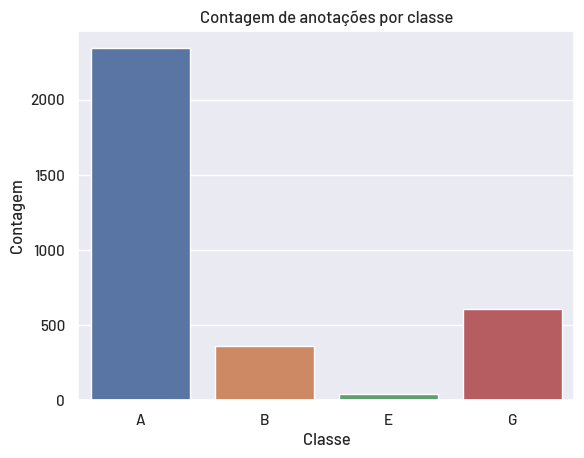

In [8]:
# Conta a quantidade de anotações por classe
sns.countplot(x='class', data=annotations_df)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Contagem de anotações por classe')
plt.show()

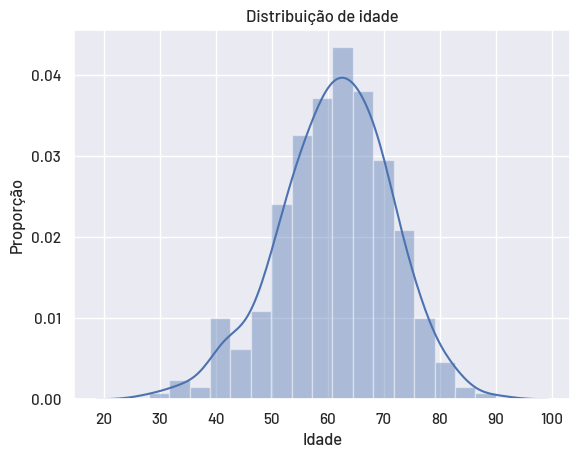

In [9]:
# Exibe um as estatísticas de idade
sns.distplot(stats_df['Age'])
plt.xlabel('Idade')
plt.ylabel('Proporção')
plt.title('Distribuição de idade')
plt.show()

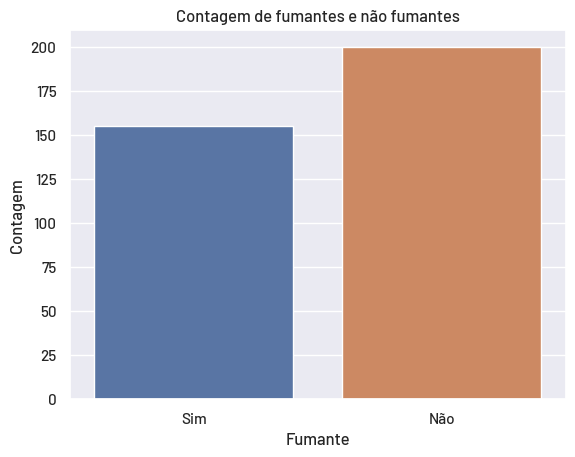

In [10]:
# Exibe a quantidade de fumantes e não fumantes
sns.countplot(x='Smoking History', data=stats_df.replace({0: 'Não', 1: 'Sim'}))
plt.xlabel('Fumante')
plt.ylabel('Contagem')
plt.title('Contagem de fumantes e não fumantes')
plt.show()

---

## 3. Treinamento do modelo

> Realizado em ``yolo_model.ipynb``

* Execução no Google Colab (com 15Gb de GPU), aproximadamente 4 horas
* Foi usado um modelo pré-treinado (Transfer Learning)
* 300 épocas, batch automático e imagens 512x512

---

## 4. Resultados

### 4.1 **Funções úteis para visualização**

In [39]:
def plot_bounding_box(annotation_file):
    """
    Visualiza a anotação de uma imagem
    """

    class_dict = {class_name: i for i, class_name in enumerate(['A', 'B', 'E', 'G'])}

    with open(annotation_file, "r") as file:
        annotation_list = file.read().split("\n")[:-1]
        annotation_list = [x.split(" ") for x in annotation_list]
        annotation_list = [[float(y) for y in x] for x in annotation_list]

    # Get the corresponding image file
    image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
    assert os.path.exists(image_file)

    # Load the image
    image = Image.open(image_file)

    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h

    transformed_annotations[:, 1] = transformed_annotations[:,
                                                            1] - (transformed_annotations[:, 3] / 2)
    transformed_annotations[:, 2] = transformed_annotations[:,
                                                            2] - (transformed_annotations[:, 4] / 2)
    transformed_annotations[:, 3] = transformed_annotations[:,
                                                            1] + transformed_annotations[:, 3]
    transformed_annotations[:, 4] = transformed_annotations[:,
                                                            2] + transformed_annotations[:, 4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))
        plotted_image.text((x0, y0 - 10), list(class_dict)[(int(obj_cls))])

    plt.imshow(np.array(image), cmap="Greys_r")
    plt.title("Bounding box original")
    plt.show()

In [40]:
def plot_image(file, title):
    """
    Visualiza uma imagem
    """
    
    image = Image.open(file)
    plt.imshow(np.array(image), cmap="Greys_r")
    plt.title(title)
    plt.show()

### 4.2 **Usando o modelo treinado**

In [41]:
# Cria o modelo a partir do arquivo
model = YOLO('../models/yolo/10-sample/best.pt')

In [84]:
%%capture

# Itera sobre o diretório de validação
for image_file in os.listdir('../data/test/images/'):
    model.predict(source='../data/test/images/' + image_file, save=True) 


image 1/1 /home/matheus/Desktop/Projetos/lung-cancer/notebooks/../data/test/images/G0050_5.jpg: 512x512 1 G, 12.2ms
Speed: 11.1ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2

image 1/1 /home/matheus/Desktop/Projetos/lung-cancer/notebooks/../data/test/images/A0114_0.jpg: 512x512 1 A, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2

image 1/1 /home/matheus/Desktop/Projetos/lung-cancer/notebooks/../data/test/images/A0236_0.jpg: 512x512 1 A, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2

image 1/1 /home/matheus/Desktop/Projetos/lung-cancer/notebooks/../data/test/images/A0123_0.jpg: 512x512 1 A, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/

In [97]:
image = "A0055_2"

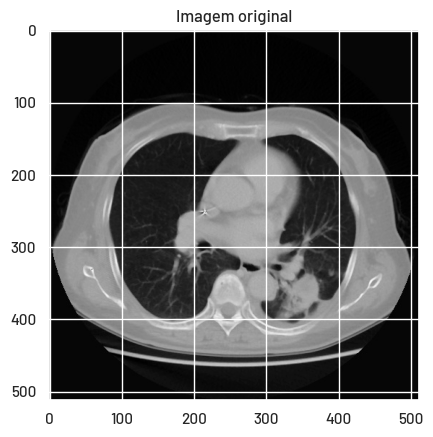

In [98]:
# Imagem original
plot_image("../data/test/images/{}.jpg".format(image), "Imagem original")

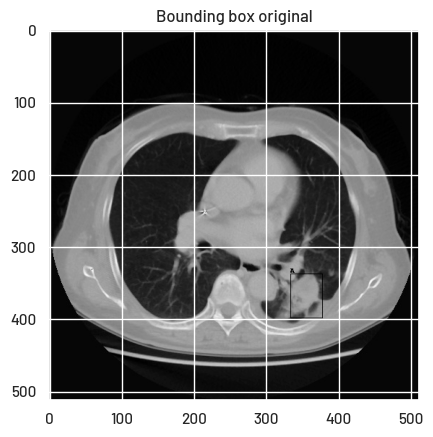

In [99]:
# Imagem com anotação
plot_bounding_box("../data/test/labels/{}.txt".format(image))

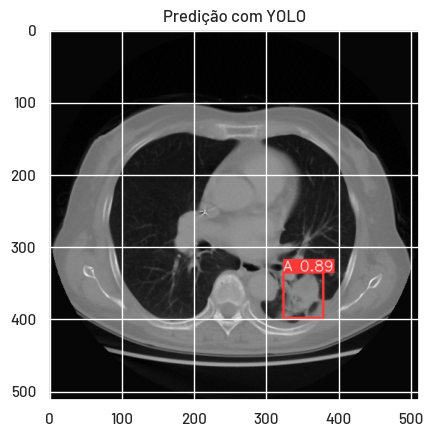

In [100]:
plot_image("runs/detect/predict2/{}.jpg".format(image), "Detecção com YOLO")

---

## 5. Avaliação

In [46]:
# Lê o arquivo de resultados
results_df = pd.read_csv('../models/yolo/10-sample/runs/detect/train/results.csv')
results_df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,2.24330,4.98120,1.72730,0.00211,0.52937,0.03019,0.01240,1.7749,4.44580,1.3638,0.000262,0.000262,0.000262
1,1,1.85300,2.92910,1.34700,0.00172,0.53169,0.03119,0.01272,1.8371,4.49540,1.4663,0.000536,0.000536,0.000536
2,2,1.81240,2.53710,1.32710,0.00235,0.66543,0.13328,0.05913,1.7949,3.93040,1.3711,0.000807,0.000807,0.000807
3,3,1.82090,2.30420,1.34090,0.00237,0.39055,0.08894,0.03757,1.9206,3.97480,1.5298,0.001077,0.001077,0.001077
4,4,1.80990,2.18020,1.32600,0.50097,0.04136,0.10939,0.04472,2.0212,3.29730,1.4993,0.001234,0.001234,0.001234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0.84682,0.42233,0.92113,0.88022,0.89591,0.92684,0.56127,1.4117,0.56486,1.2599,0.000037,0.000037,0.000037
296,296,0.85054,0.42733,0.91944,0.88117,0.89475,0.92711,0.56237,1.4122,0.56644,1.2599,0.000033,0.000033,0.000033
297,297,0.84180,0.42220,0.91774,0.88241,0.89146,0.92701,0.56453,1.4108,0.56349,1.2591,0.000029,0.000029,0.000029
298,298,0.85781,0.43079,0.92406,0.88908,0.89419,0.93171,0.56197,1.4122,0.56350,1.2609,0.000025,0.000025,0.000025


In [58]:
# Remove caracteres especiais dos nomes das colunas
results_df.columns = results_df.columns.str.replace('[#,@,&,?, ]', '')
results_df.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

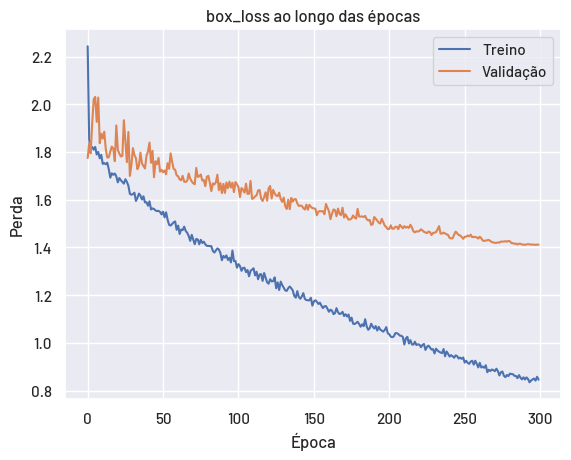

In [62]:
# Exibe a perda de box_loss ao longo das épocas no treino e validação
sns.lineplot(x='epoch', y='train/box_loss', data=results_df, label='Treino')
sns.lineplot(x='epoch', y='val/box_loss', data=results_df, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('box_loss ao longo das épocas')
plt.show()

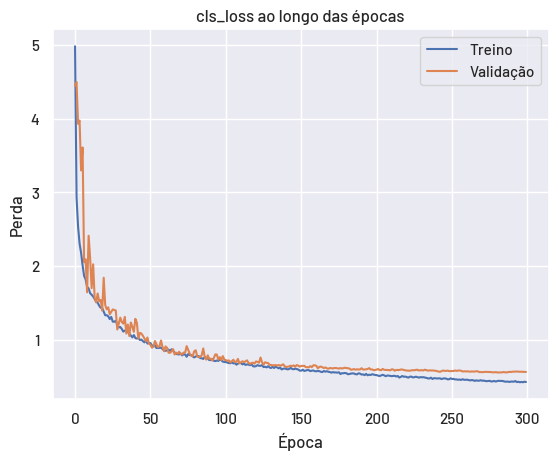

In [64]:
# Exibe a perda de cls_loss ao longo das épocas no treino e validação
sns.lineplot(x='epoch', y='train/cls_loss', data=results_df, label='Treino')
sns.lineplot(x='epoch', y='val/cls_loss', data=results_df, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('cls_loss ao longo das épocas')
plt.show()

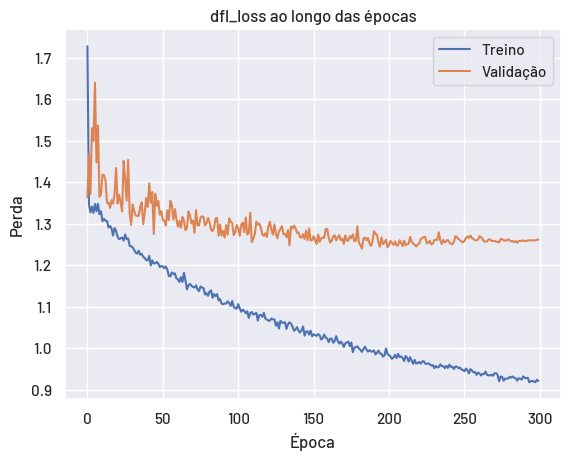

In [65]:
# Exibe a perda de dfl_loss ao longo das épocas no treino e validação
sns.lineplot(x='epoch', y='train/dfl_loss', data=results_df, label='Treino')
sns.lineplot(x='epoch', y='val/dfl_loss', data=results_df, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('dfl_loss ao longo das épocas')
plt.show()

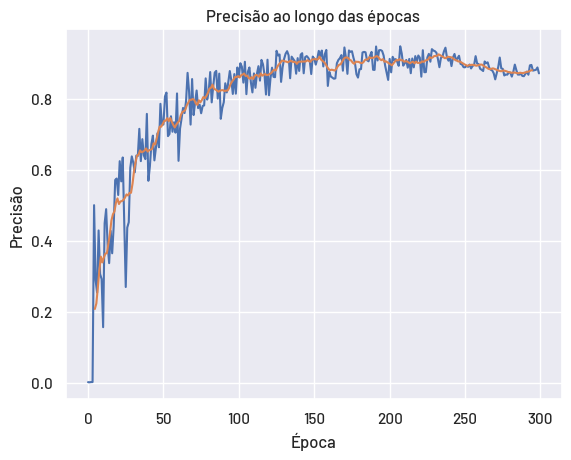

In [70]:
# Exibe a precisão ao longo das épocas de treino
sns.lineplot(x='epoch', y='metrics/precision(B)', data=results_df)
sns.lineplot(x='epoch', y='metrics/precision(B)', data=results_df.rolling(10).mean())
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.title('Precisão ao longo das épocas')
plt.show()

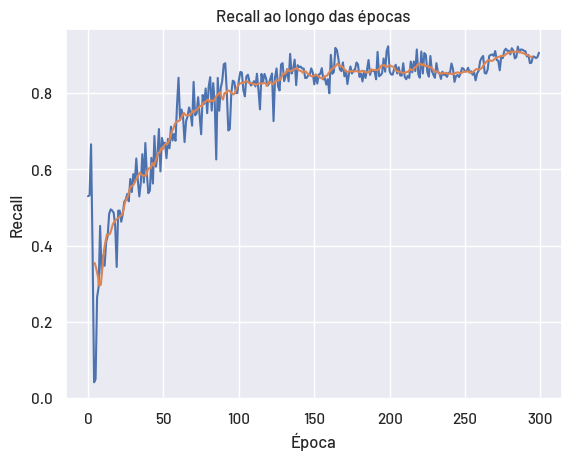

In [71]:
# Exibe o recall ao longo das épocas de treino
sns.lineplot(x='epoch', y='metrics/recall(B)', data=results_df)
sns.lineplot(x='epoch', y='metrics/recall(B)', data=results_df.rolling(10).mean())
plt.xlabel('Época')
plt.ylabel('Recall')
plt.title('Recall ao longo das épocas')
plt.show()